In [1]:
from keras.applications.inception_v3 import InceptionV3
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Model
from keras.layers import Dense, GlobalAveragePooling2D
import matplotlib.pyplot as plt
import h5py
from keras.applications.resnet50 import preprocess_input, decode_predictions
from keras.callbacks import TensorBoard, ModelCheckpoint
import datetime

import numpy as np

def get_file_name ():
    now = datetime.datetime.now()
    return "%d%d%d-%d%d" % (now.year, now.month, now.day, now.hour, now.minute)

def get_tensor_board () :
    return TensorBoard(log_dir='./logs/' + get_file_name()  + '/', histogram_freq=0,
                          write_graph=True, write_images=False)


import scipy.io
labelMat = scipy.io.loadmat('utils/imagelabels.mat')

## Configure everything (hard coded .a.t.m.)
nr_labels = 5 
batch_size = 32
nr_epochs = 2
num_samples = 3620
num_valid_samples = 50


Using TensorFlow backend.


Found 3620 images belonging to 5 classes.
Found 50 images belonging to 5 classes.
Image batch shape:  (32, 150, 150, 3)
Labe batch shape:  (32, 5)


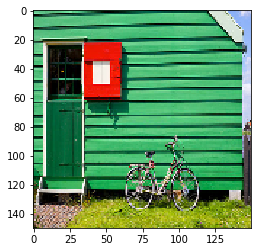

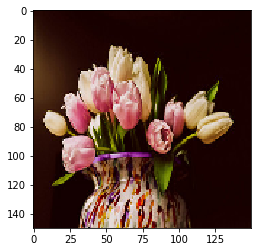

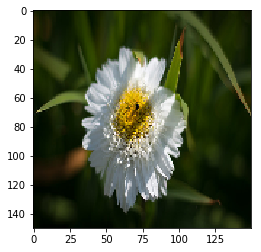

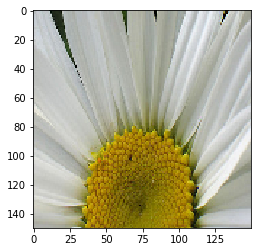

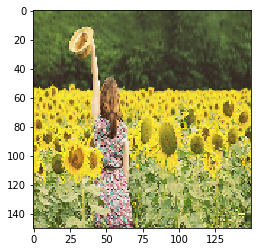

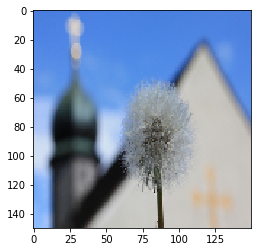

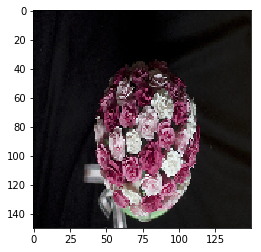

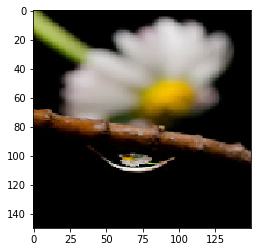

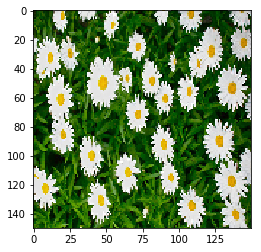

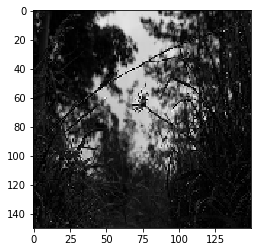

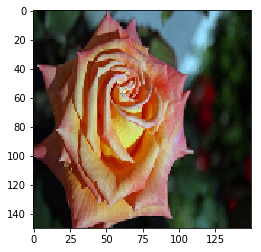

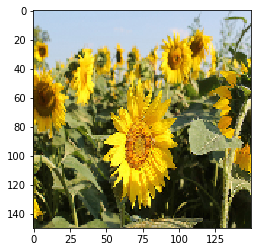

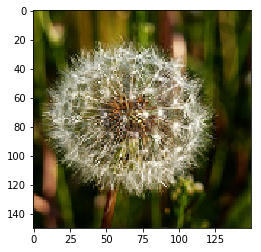

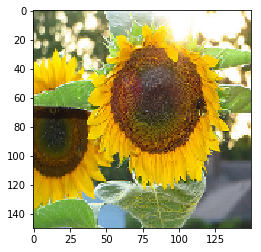

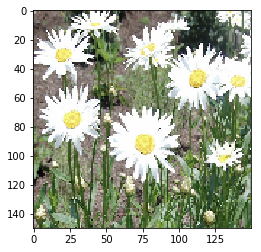

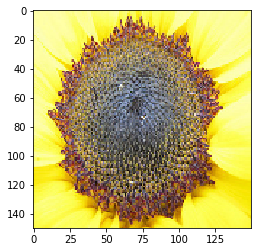

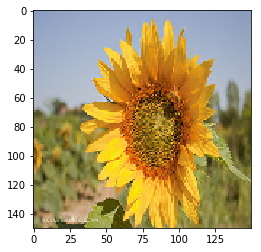

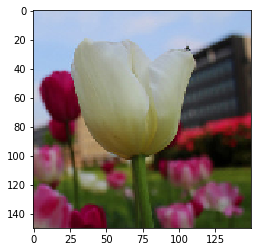

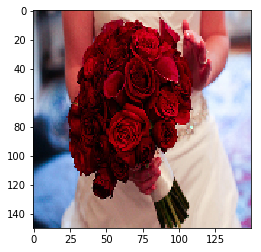

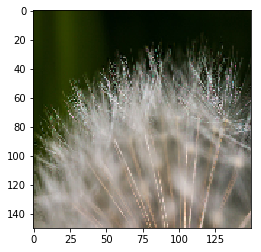

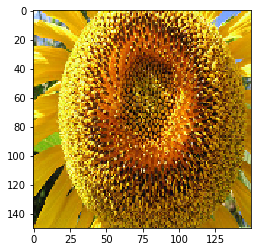

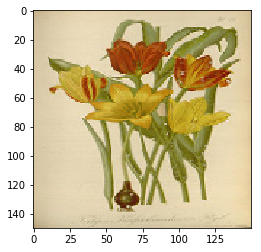

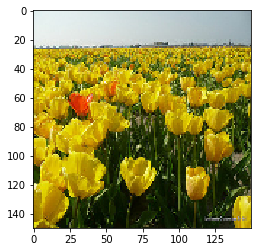

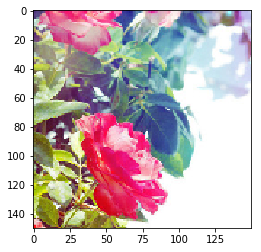

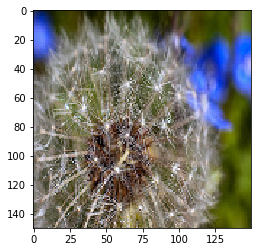

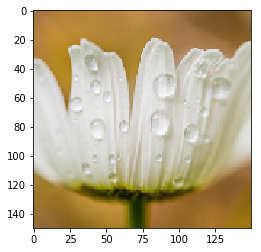

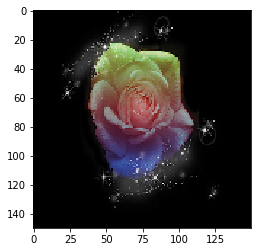

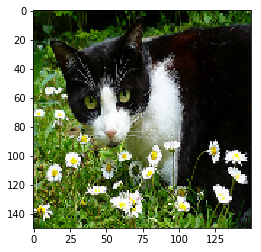

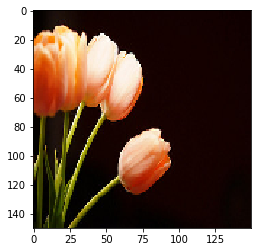

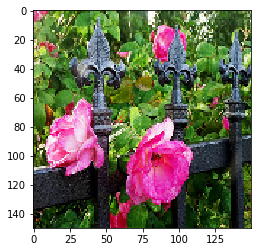

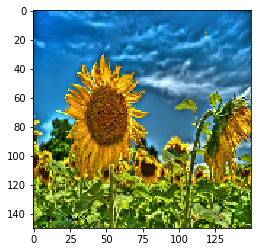

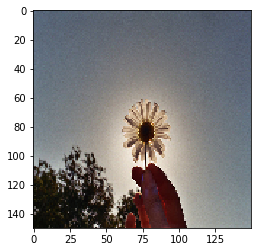

In [2]:
def get_generator (folder, batch_size=32):
    train_datagen = ImageDataGenerator(
        rescale=1./255,
        horizontal_flip=True)

    train_generator = train_datagen.flow_from_directory(
        folder,
        target_size=(150, 150),
        batch_size=batch_size,
        class_mode='categorical')
    
    return train_generator
train_generator = get_generator('flower_photos_splitted/train', batch_size=batch_size)
valid_generator = get_generator('flower_photos_splitted/valid', batch_size=batch_size)

for image_batch,label_batch in valid_generator:
  print("Image batch shape: ", image_batch.shape)
  print("Labe batch shape: ", label_batch.shape)
  for image in image_batch:
    plt.imshow(image)
    plt.show()
  break

In [3]:

def get_model ():
    base_model = InceptionV3(weights='imagenet', include_top=False)

    # add a global spatial average pooling layer
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    # let's add a fully-connected layer
    x = Dense(1024, activation='relu')(x)
    # and a logistic layer -- let's say we have 200 classes
    predictions = Dense(nr_labels, activation='softmax')(x)

    # this is the model we will train
    model = Model(inputs=base_model.input, outputs=predictions)
    
    for layer in model.layers[:1]:
        layer.trainable = False
    
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    
    return model


model = get_model()
# model.load_weights('models/2019411-224.h5') 
model.summary()

Instructions for updating:
Colocations handled automatically by placer.
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, None, None, 3 0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, None, None, 3 864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, None, None, 3 96          conv2d_1[0][0]                   
__________________________________________________________________________________________________
activation_1 (Activation)       (None, None, None, 3 0           batch_normalization_1[0][0]      
_____________________________________

activation_88 (Activation)      (None, None, None, 3 0           batch_normalization_88[0][0]     
__________________________________________________________________________________________________
activation_89 (Activation)      (None, None, None, 3 0           batch_normalization_89[0][0]     
__________________________________________________________________________________________________
activation_92 (Activation)      (None, None, None, 3 0           batch_normalization_92[0][0]     
__________________________________________________________________________________________________
activation_93 (Activation)      (None, None, None, 3 0           batch_normalization_93[0][0]     
__________________________________________________________________________________________________
batch_normalization_94 (BatchNo (None, None, None, 1 576         conv2d_94[0][0]                  
__________________________________________________________________________________________________
activation

In [4]:

print('evaluate')
loss = model.evaluate_generator(valid_generator, 
                    steps= num_valid_samples / batch_size)
print(loss)



evaluate
[2.738807325363159, 0.12000000014901162]


[0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2 2 2 2 3 3 3 3 3 3 3
 3 3 3 4 4 4 4 4 4 4 4 4 4]
{0: 'daisy', 1: 'dandelion', 2: 'roses', 3: 'sunflowers', 4: 'tulips'}
(32, 5)
daisy


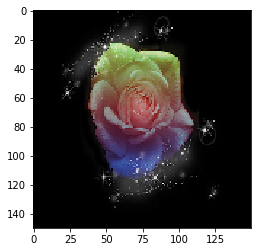

daisy


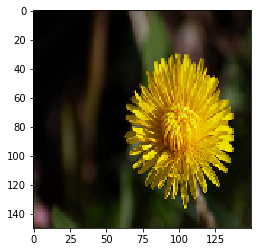

sunflowers


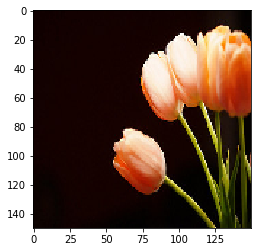

daisy


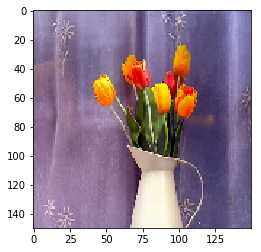

daisy


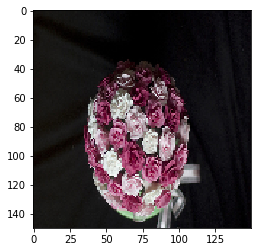

daisy


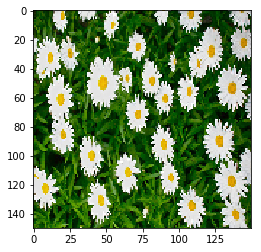

roses


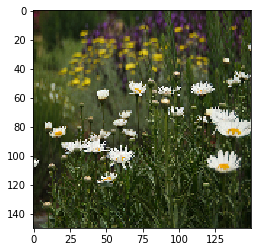

tulips


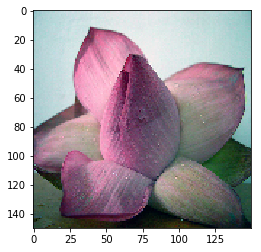

sunflowers


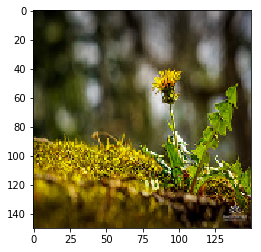

daisy


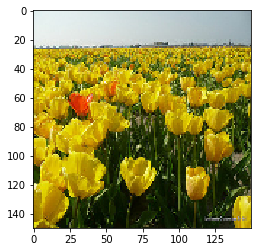

daisy


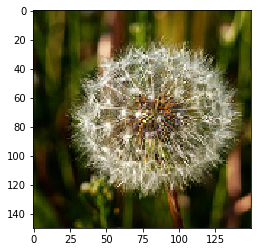

daisy


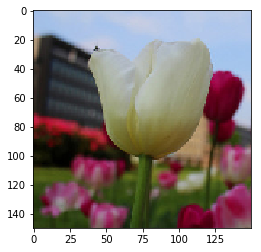

daisy


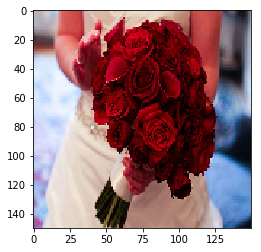

daisy


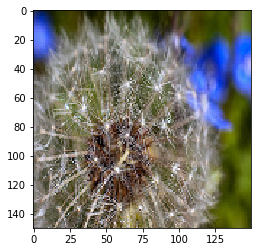

tulips


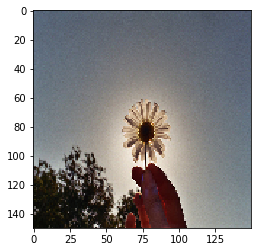

roses


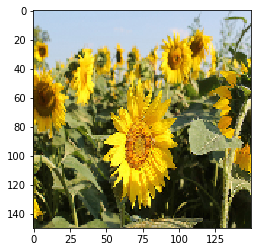

daisy


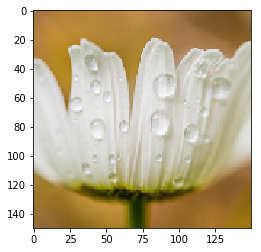

daisy


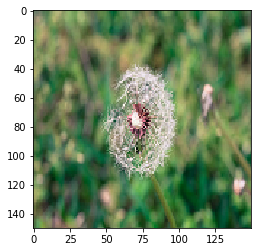

daisy


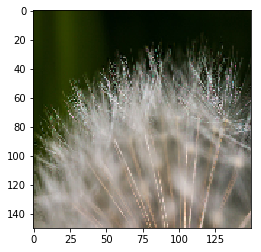

daisy


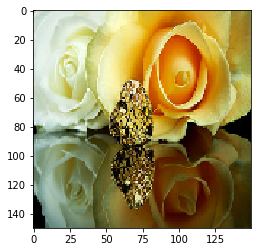

daisy


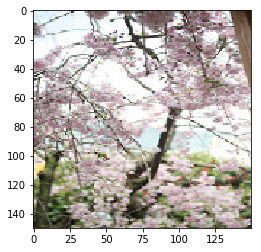

daisy


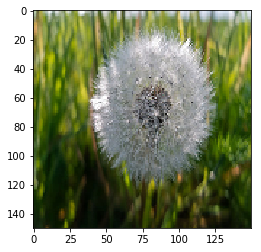

daisy


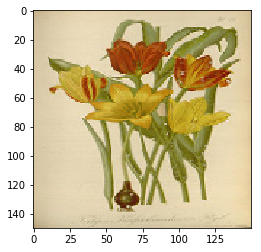

daisy


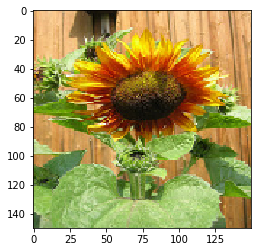

daisy


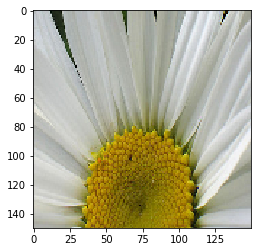

daisy


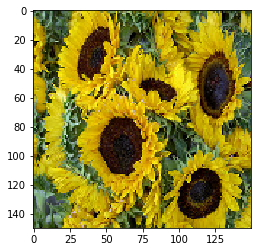

roses


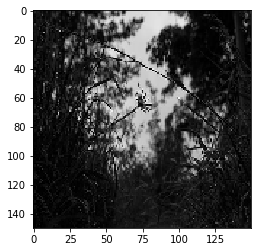

sunflowers


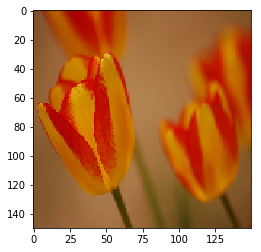

daisy


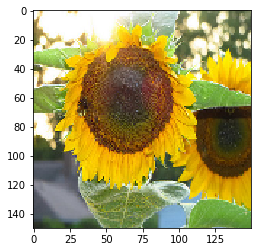

sunflowers


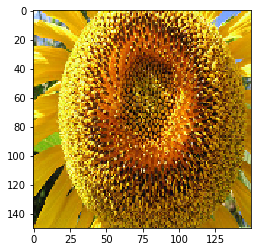

daisy


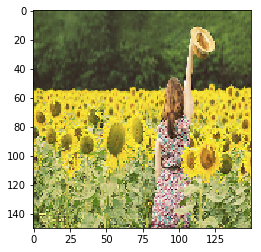

daisy


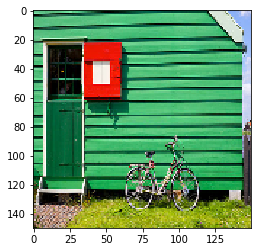

In [5]:
classes = valid_generator.classes
class_indices = valid_generator.class_indices
class_names = {}
for k, v in class_indices.items():
    class_names[v] = k
    
for image_data, something_else in valid_generator:
    res = model.predict(image_data)
    for index, image in enumerate(image_data):
        predicted_class = np.argmax(res[index], axis=-1)
        print(class_names[predicted_class])
        plt.imshow(image)
        plt.show()
    break

In [ ]:

print('train')
model.fit_generator(train_generator, 
                    epochs=100,
                    steps_per_epoch= num_samples / batch_size, 
                    validation_data=valid_generator,
                    validation_steps = num_valid_samples / batch_size,
                    callbacks=[
                        get_tensor_board(),
                        ModelCheckpoint('models/%s.h5'% get_file_name(), verbose=1, save_best_only=True)
                    ])



train
Epoch 1/100
114/113 [==============================] - 731s 6s/step - loss: 1.0007 - acc: 0.6872 - val_loss: 9.6597 - val_acc: 0.1800

Epoch 00001: val_loss improved from inf to 9.65969, saving model to models/2019411-224.h5
Epoch 2/100
114/113 [==============================] - 714s 6s/step - loss: 0.7635 - acc: 0.7473 - val_loss: 1.7176 - val_acc: 0.7200

Epoch 00002: val_loss improved from 9.65969 to 1.71759, saving model to models/2019411-224.h5
Epoch 3/100
114/113 [==============================] - 714s 6s/step - loss: 0.5808 - acc: 0.8007 - val_loss: 0.5222 - val_acc: 0.8000

Epoch 00003: val_loss improved from 1.71759 to 0.52224, saving model to models/2019411-224.h5
Epoch 4/100
114/113 [==============================] - 714s 6s/step - loss: 0.7350 - acc: 0.7421 - val_loss: 4.1938 - val_acc: 0.4400

Epoch 00004: val_loss did not improve from 0.52224
Epoch 5/100
114/113 [==============================] - 713s 6s/step - loss: 0.6666 - acc: 0.7678 - val_loss: 2.4242 - val_acc

In [ ]:
model.evaluate_generator(generator=valid_generator, steps= num_valid_samples / batch_size)

In [ ]:
model.predict_generator()